In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.3.1


In [12]:
import pathlib
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar = True)
print(data_dir)
data_dir = pathlib.Path(data_dir)
print(data_dir)

C:\Users\June\.keras\datasets\flower_photos
C:\Users\June\.keras\datasets\flower_photos


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


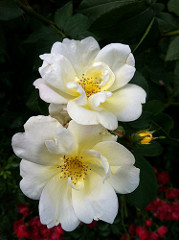

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

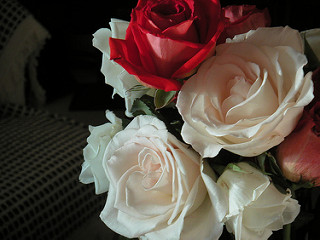

In [13]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [14]:
batch_size = 32
img_height = 180
img_width = 180

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


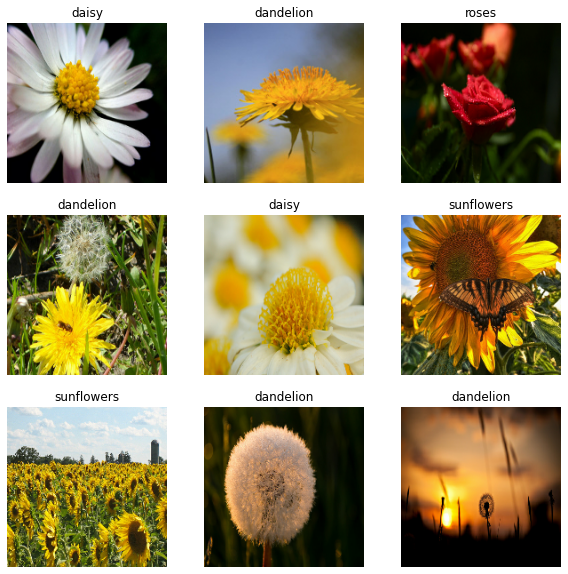

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [26]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [27]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [42]:
num_classes = 5

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32,3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [43]:
model.compile(optimizer='adam',
              loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model.fit(train_ds, validation_data = val_ds, epochs=3)

Epoch 1/3
92/92 [==============================] - 9s 96ms/step - loss: 1.2474 - accuracy: 0.4639 - val_loss: 1.0672 - val_accuracy: 0.5763
Epoch 2/3
92/92 [==============================] - 3s 37ms/step - loss: 0.9931 - accuracy: 0.6141 - val_loss: 0.9433 - val_accuracy: 0.6253
Epoch 3/3
92/92 [==============================] - 3s 37ms/step - loss: 0.8450 - accuracy: 0.6815 - val_loss: 0.8919 - val_accuracy: 0.6444


In [45]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [46]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\June\\.keras\\datasets\\flower_photos\\sunflowers\\1267876087_a1b3c63dc9.jpg'
b'C:\\Users\\June\\.keras\\datasets\\flower_photos\\daisy\\11891885265_ccefec7284_n.jpg'
b'C:\\Users\\June\\.keras\\datasets\\flower_photos\\dandelion\\11405573_24a8a838cc_n.jpg'
b'C:\\Users\\June\\.keras\\datasets\\flower_photos\\tulips\\8708856019_f3be2353a4_n.jpg'
b'C:\\Users\\June\\.keras\\datasets\\flower_photos\\roses\\16374919860_4e445de29f_n.jpg'


In [47]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [48]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [49]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [50]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [52]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [53]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [54]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [55]:
for image, label in train_ds.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())

Image shape: (180, 180, 3)
Label: 0


In [56]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

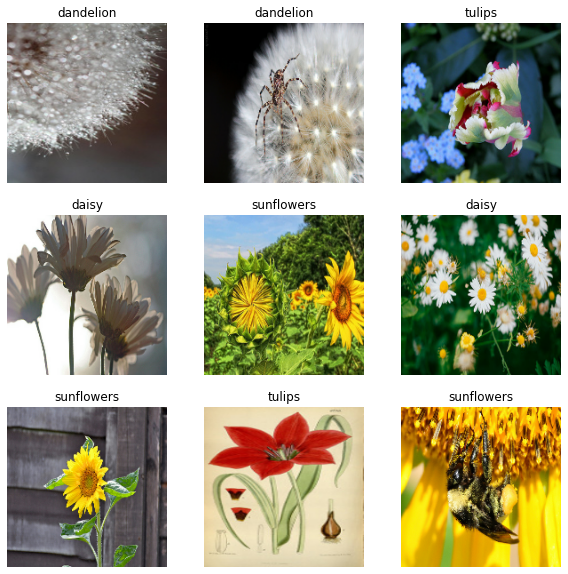

In [57]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis('off')

In [58]:
model.fit( train_ds, validation_data = val_ds, epochs=3)

Epoch 1/3
92/92 [==============================] - 4s 44ms/step - loss: 0.7482 - accuracy: 0.7238 - val_loss: 0.7434 - val_accuracy: 0.6948
Epoch 2/3
92/92 [==============================] - 4s 40ms/step - loss: 0.5523 - accuracy: 0.7977 - val_loss: 0.7987 - val_accuracy: 0.7030
Epoch 3/3
92/92 [==============================] - 4s 40ms/step - loss: 0.3879 - accuracy: 0.8546 - val_loss: 0.8036 - val_accuracy: 0.7098


In [60]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [61]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


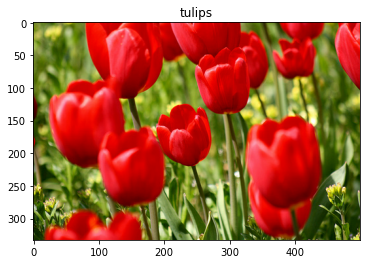

In [64]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [69]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)